# Import libraies

In [50]:
import torch, torchvision
from torch import nn
from torch import optim #stochastic gradient descent (SGD) as the training algorithm
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

import requests
from PIL import Image
from io import BytesIO


from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

In [51]:
numb_batch = 64

# Getting data

In [52]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

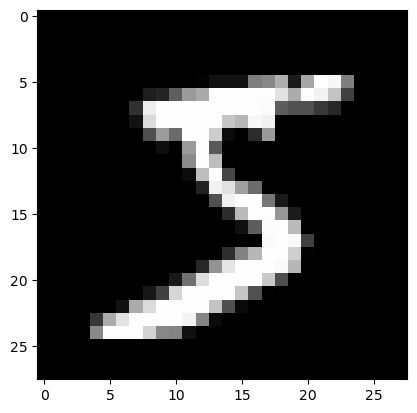

In [53]:
plt.imshow(train_data[0][0][0], cmap="gray")

# Create the Model

In [54]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

# Validate the Model

In [55]:
def validate(model, data):
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.to("cpu")  # Move images to CPU
        x = model(images)
        value, pred = torch.max(x, 1)
        correct += (pred == labels).sum().item()
    accuracy = 100 * correct / len(data.dataset)
    return accuracy


# Training function

In [56]:
import torch.optim as optim

def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cnn.parameters(), lr=lr)#stochastic gradient descent (SGD) as the training algorithm
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy:", accuracy)
        print('Epoch:', epoch+1, "Accuracy:", accuracy, '%')
    plt.plot(accuracies)
    return best_model


#lenet = train(40, device="cpu")


# GPU Availability

In [57]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")

No Cuda Available


In [60]:
device

device(type='cpu')

# Traning the Model

Saving Best Model with Accuracy: 8.91
Epoch: 1 Accuracy: 8.91 %
Saving Best Model with Accuracy: 10.29
Epoch: 2 Accuracy: 10.29 %
Epoch: 3 Accuracy: 10.28 %
Epoch: 4 Accuracy: 10.28 %
Epoch: 5 Accuracy: 10.28 %
Saving Best Model with Accuracy: 19.44
Epoch: 6 Accuracy: 19.44 %
Epoch: 7 Accuracy: 11.46 %
Epoch: 8 Accuracy: 11.35 %
Epoch: 9 Accuracy: 11.35 %
Epoch: 10 Accuracy: 11.35 %
Epoch: 11 Accuracy: 11.35 %
Epoch: 12 Accuracy: 11.35 %
Epoch: 13 Accuracy: 11.35 %
Epoch: 14 Accuracy: 11.35 %
Epoch: 15 Accuracy: 11.35 %
Epoch: 16 Accuracy: 11.36 %
Epoch: 17 Accuracy: 12.2 %
Epoch: 18 Accuracy: 17.69 %
Saving Best Model with Accuracy: 23.59
Epoch: 19 Accuracy: 23.59 %
Saving Best Model with Accuracy: 27.43
Epoch: 20 Accuracy: 27.43 %
Saving Best Model with Accuracy: 29.82
Epoch: 21 Accuracy: 29.82 %
Saving Best Model with Accuracy: 34.45
Epoch: 22 Accuracy: 34.45 %
Saving Best Model with Accuracy: 52.13
Epoch: 23 Accuracy: 52.13 %
Saving Best Model with Accuracy: 75.58
Epoch: 24 Accurac

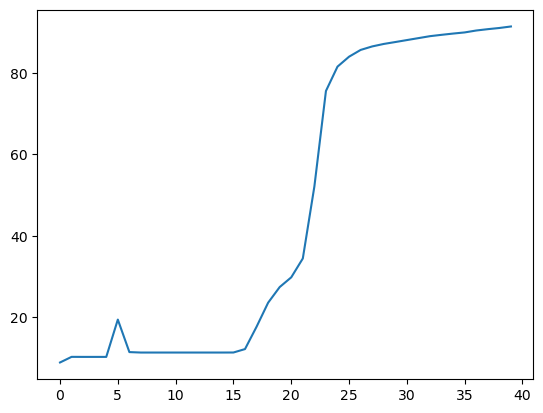

In [61]:
lenet = train(40, device="cpu")

In [82]:
torch.save(lenet.state_dict(), "lenet.pth")


In [83]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        #images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        #pred = pred.data.cpu()
        pred = pred.data#remove cpu, the .cpu() method is unnecessary when you want to work with the data on the CPU.
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [84]:
y_pred, y_true = predict_dl(lenet, val_dl)


In [85]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))


,0,1,2,3,4,5,6,7,8,9
0,957,0,0,3,0,7,8,1,4,0
1,0,1117,3,2,0,2,2,1,8,0
2,11,6,911,17,16,6,19,15,27,4
3,3,6,12,918,0,29,2,11,20,9
4,2,4,6,1,860,2,17,0,5,85
5,11,3,3,31,12,800,8,2,16,6
6,14,5,3,4,10,21,898,1,2,0
7,1,12,23,8,6,1,1,910,3,63
8,11,7,1,43,9,24,9,10,848,12
9,10,8,3,10,31,8,1,10,5,923


# Define Inference Function

In [86]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

In [90]:
path = "https://c8.alamy.com/comp/HXBRW0/2-red-handwritten-digits-over-white-background-HXBRW0.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

# Show Image

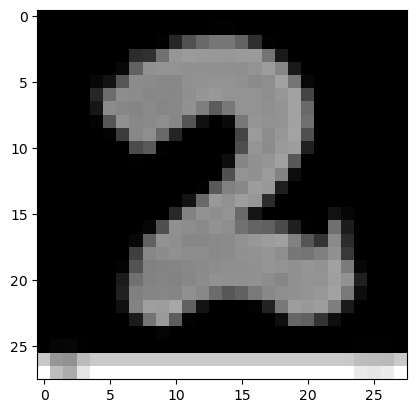

In [91]:
plt.imshow(x.squeeze(-1), cmap="gray")


In [93]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 2, Prob: 96.12510204315186 %


In [94]:
pred

array([[7.1509106e-08, 1.4465910e-04, 9.6125102e-01, 3.8020354e-02,
        2.9692618e-10, 4.3022774e-05, 7.1807740e-08, 8.5248928e-08,
        5.4073357e-04, 6.6690662e-09]], dtype=float32)